------------------------------------------------------------------------------------------
| | |
|:----------|:----------|
| Name      | Bayesian Modeling |
| Notebook  |  Combining posterior estimates|
| Notes | Hierarchical Example: Sampling in a hierarhical model| 
| Author    | Joshuah Touyz, PhD |
| Version   | 0.1 |
|Last update| 08/01/20 |
-------------------------------------------------------------------------------------------

### Simple Hierarchical Gibbs Sampler
$$
\begin{align}
\mu&\sim N(\mu_0,\tau_0^2)\\
\mu_j&\sim N(\mu,\tau^2),\quad j=1,...,J\\
X&|\mu_j\sim N(\mu_j,\sigma^2),\quad j=1,...,J
\end{align}
$$

In [1]:
# Import librarires
import numpy as np
import pandas as pd
import plotnine as pn
import scipy as sp

# Plot configurations
pn.options.figure_size = (10,2)
pn.options.dpi = 125# Import librarires

In [2]:
# Data 
x_america = np.array([1000, 2000, 3000, 2000])
x_europe = np.array([500, 600, 700, 800, 900])
x_asia = np.array([2000, 2500, 3500, 1500])

# Constants
mu_0 = 1800 #<- mu_j centered around this value
tau_0_2 = 300 # <- mu_js will be proportionally distributed within np.sqrt(300) of mu_j
tau_2 = 400
sigma_2 = 300 




#### Posterior
$$
\begin{align*}
\mu_j|\mathbf{x}_j,\mu & \sim N(p_j\bar{x}+(1-p_j)\mu, V_j)\\
V_j &= \left(\frac{n_j}{\sigma^2}+\frac{1}{\tau^2}\right)^{-1}\\
p_j &= \frac{n_j}{\sigma^2}\times V_j 
\end{align*}
$$


In [3]:
# Posteriors 
def posterior_j(x, mu, tau_2, sigma_2):
    # Posterior variance
    post_v_j = (len(x)/sigma_2 + 1/tau_2)**(-1)
    
    # Posterior mean
    p_j = (len(x)/sigma_2) * (post_v_j)
    post_m_j = p_j * x.mean() + (1-p_j) * mu

    # Simulate from posterior distribution
    out = sp.random.normal(loc = post_m_j, scale = np.sqrt(post_v_j), size = 1)

    return(out)

### Hyperposterior
$$
\begin{align*}
\mu|\mu_j & \sim N(q\bar{\mu}+(1-p)\mu_0, V)\\
V &= \left(\frac{J}{\tau^2}+\frac{1}{\tau_0^2}\right)^{-1}\\
q &= \frac{J}{\tau^2}\times V 
\end{align*}
$$



In [4]:
# Hyperposterior
def hyperposterior(mu_j, mu_0, tau_0_2, tau_2):
    # Recursively defined so we have:
    out = posterior_j(mu_j, mu_0, tau_0_2, tau_2)
    return(out)

In [5]:
### Gibbs Sampler ###
# Warm Start
mu_ws_america = x_america.mean()
mu_ws_europe = x_europe.mean()
mu_ws_asia = x_asia.mean()

# Warmstart values
mu_j_ws_in = np.array(([mu_ws_america, mu_ws_europe, mu_ws_asia]))

# Simulated values of posterior, hyperposterior
number_of_samples = 10000
number_of_geographies = 3
burn_in = 100 # <- the first 100 values will be discarded so that we have stable estimates

# Pre populate arrays
mu = np.zeros(number_of_samples)
mu_js = np.zeros((number_of_samples,number_of_geographies))

In [6]:
# Gibbs Sampler
for i in np.arange(0,number_of_samples):
    
    # Warm start - hyperposterior
    if i == 0:
        mu[0] = hyperposterior(mu_j_ws_in, mu_0, tau_0_2, tau_2)
    else:
        mu[i] = hyperposterior(mu_js[(i-1),:], mu_0, tau_0_2, tau_2)
    
    # Updating posterior
    mu_js[i,0] = posterior_j(x_america, mu[i], tau_2, sigma_2) # posterior mu_america
    mu_js[i,1]  = posterior_j(x_europe, mu[i], tau_2, sigma_2) # posterior mu_europe
    mu_js[i,2]  = posterior_j(x_asia, mu[i], tau_2, sigma_2) # posterior mu_asia

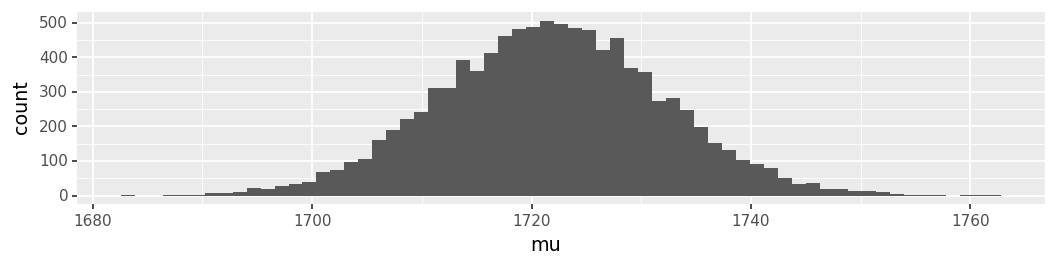

<ggplot: (-9223372036533572562)>

In [9]:
# Plotting histogram
hyperposterior = pd.DataFrame({'mu':mu[burn_in:]})
pn.ggplot(pn.aes(x = 'mu'), data = hyperposterior) + pn.geom_histogram()

In [10]:
# Plotting histogram
posterior = pd.DataFrame({'mu_america':mu_js[burn_in:,0], 'mu_europe':mu_js[burn_in:,1], 'mu_asia':mu_js[burn_in:,2]})
posterior = posterior.unstack().reset_index().drop('level_1',axis =1).rename({'level_0':'posterior', 0:'mu_j'}, axis= 1)
posterior.head()

,posterior,mu_j
0,mu_america,1960.326780
1,mu_america,1957.143585
2,mu_america,1946.934385
3,mu_america,1948.059830
4,mu_america,1954.762776


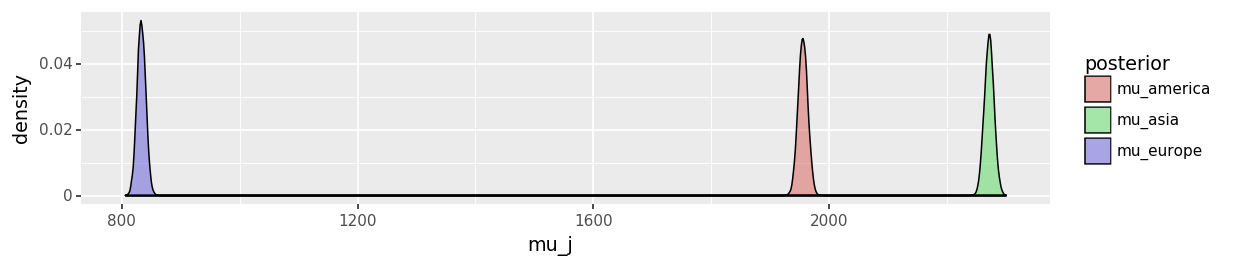

<ggplot: (-9223372036583458749)>

In [11]:
pn.ggplot(pn.aes(x = 'mu_j', fill = 'posterior', group = 'posterior'), data = posterior)\
    + pn.geom_density(alpha = 0.5)

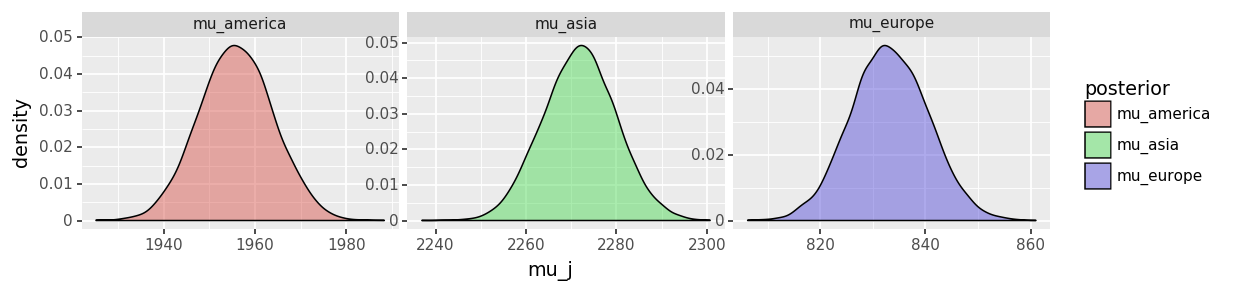

<ggplot: (321216667)>

In [12]:
pn.ggplot(pn.aes(x = 'mu_j', fill = 'posterior', group = 'posterior'), data = posterior)\
    + pn.geom_density(alpha = 0.5)\
    + pn.facet_wrap('posterior', scales = 'free')

- Note that the hyperposterior has a regularizing effect.
- This is most apparent with the distribution the posterior of Europe.

- Notice that if we were to use a flat prior then the $\mu_{Europe}|\mathbf{x}_{Europe},\mu$ would be centered at $\bar{x}=700$, it's distribution here however is centered around 870.

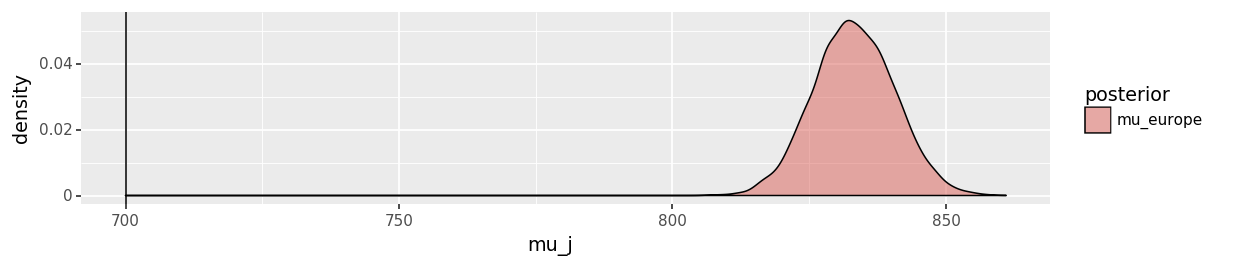

<ggplot: (321434621)>

In [13]:
pn.ggplot(pn.aes(x = 'mu_j', fill = 'posterior', group = 'posterior'), data = posterior[posterior.posterior == 'mu_europe'])\
    + pn.geom_density(alpha = 0.5)\
    + pn.geom_vline(pn.aes(xintercept = x_europe.mean()))

Four notes:
- The variance of the prior is very small and consequently has a strong regularizing effect. If it were to be increased then the priors would move closer to their respective means
- In principle we could have also estimated the variance for the posterior distributions $\{\mu_{America},\mu_{Europe},\mu_{Asia}\}$, rather than assuming they were fixed. The mechanics for calculating the hierarchical variance are the same as for the means and is left as an exercise
- In general we will use software to do these calculations however it is helpful to understand how to derive these relationships, especially if you are looking to make a customized sampler
- This hierarchical model is akin to a simple hierarchical linear regression with indicators, we'll see how to do Bayesian regression in the computational module of this course - so stay tuned!